# WIP Data augmentation 


In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf


import pathlib
import pandas as pd

import pydicom # for DICOM images
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
print(tf.__version__)

2.6.0


In [2]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [3]:
# Directory
#directory = '/Users/renau/Desktop/DATA/data_proj_melanoma'
directory = '/Users/renau/Desktop/PROJ-H419/data'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

# Change columns names
new_names = ['dcm_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

Train has 33,126 rows and Test has 10,982 rows.


In [4]:
# === JPEG ===
# Create the paths
path_train = directory + '/jpeg/train/' + train_df['dcm_name'] + '.jpg'
path_test = directory + '/jpeg/test/' + test_df['dcm_name'] + '.jpg'

# Append to the original dataframes
train_df['path_jpeg'] = path_train
test_df['path_jpeg'] = path_test

In [5]:
malignant_df = train_df[train_df['target'] == 1]
malignant_df.head()

,dcm_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,path_jpeg
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1,/Users/renau/Desktop/PROJ-H419/data/jpeg/train...
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1,/Users/renau/Desktop/PROJ-H419/data/jpeg/train...
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1,/Users/renau/Desktop/PROJ-H419/data/jpeg/train...
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1,/Users/renau/Desktop/PROJ-H419/data/jpeg/train...
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1,/Users/renau/Desktop/PROJ-H419/data/jpeg/train...


In [6]:
benin_df = train_df[train_df['target'] == 0]
benin_df.head()

,dcm_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,path_jpeg
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,/Users/renau/Desktop/PROJ-H419/data/jpeg/train...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,/Users/renau/Desktop/PROJ-H419/data/jpeg/train...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,/Users/renau/Desktop/PROJ-H419/data/jpeg/train...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,/Users/renau/Desktop/PROJ-H419/data/jpeg/train...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,/Users/renau/Desktop/PROJ-H419/data/jpeg/train...


In [7]:
mal_file = malignant_df['path_jpeg'].values
mal_labels = malignant_df['target'].values
mal_train_ds = tf.data.Dataset.from_tensor_slices((mal_file, mal_labels))
len(list(mal_train_ds))

584

In [8]:
ben_file = benin_df['path_jpeg'].values
ben_labels = benin_df['target'].values
ben_train_ds = tf.data.Dataset.from_tensor_slices((ben_file, ben_labels))
len(list(ben_train_ds))

32542

In [9]:
ben_train_ds = ben_train_ds.shuffle(len(list(ben_train_ds)))
len(list(ben_train_ds))

32542

In [10]:
def make_balanced_dataset(ds_class1, ds_class2):
    half_size = min(len(list(ds_class1)),len(list(ds_class2)))
    ds_1 = ds_class1.take(half_size)
    ds_2 = ds_class2.take(half_size)
    ds_full = ds_1.concatenate(ds_2)
    ds_full = ds_full.shuffle(half_size*2, reshuffle_each_iteration=False)
    return ds_full.skip((half_size*2)//5),ds_full.take((half_size*2)//5),
#print(make_balanced_dataset(ben_train_ds,mal_train_ds))   
ds_train, ds_val = make_balanced_dataset(ben_train_ds,mal_train_ds)
size = len(list(ds_val))
print(size, len(list(ds_train)))

233 935


In [11]:
ex_ds = ds_train.take(4)
for element in ex_ds :
    print(element[0].numpy(),'and target: ',element[1].numpy())

b'/Users/renau/Desktop/PROJ-H419/data/jpeg/train/ISIC_6257422.jpg' and target:  0
b'/Users/renau/Desktop/PROJ-H419/data/jpeg/train/ISIC_0599605.jpg' and target:  1
b'/Users/renau/Desktop/PROJ-H419/data/jpeg/train/ISIC_0272026.jpg' and target:  0
b'/Users/renau/Desktop/PROJ-H419/data/jpeg/train/ISIC_2937642.jpg' and target:  1


In [12]:
def read_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, dtype = tf.uint8, expand_animations = False)
    return image, label

ds_train = ds_train.map(read_image)
ds_val = ds_val.map(read_image)

In [13]:
ex_ds = ds_train.take(3)
for element in ex_ds :
    print(element[0].numpy().shape)

(480, 640, 3)
(2448, 3264, 3)
(4000, 6000, 3)


In [14]:
def adapt_data(image, label):
    image = tf.image.resize(image, [160,160])
    return image, label

def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float64)
    return image, label
    
ds_train= ds_train.map(adapt_data).map(convert_to_float).batch(16)
ds_val= ds_val.map(adapt_data).map(convert_to_float).batch(16)

ex_ds = ds_train.take(3)
for element in ex_ds :
    print(element[0].shape)
    print(element[1].shape)

(16, 160, 160, 3)
(16,)
(16, 160, 160, 3)
(16,)
(16, 160, 160, 3)
(16,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling=None,
    classes=2,
    classifier_activation='softmax'
)

In [17]:
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 5, 5, 512)


In [18]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [19]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomContrast(factor=0.1),
    preprocessing.RandomFlip(mode='horizontal'), 
    preprocessing.RandomFlip(mode='vertical'), 
    preprocessing.RandomRotation(factor=0.20),  
])

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 512)


In [21]:
prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [22]:
inputs = tf.keras.Input(shape=(160,160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', 'binary_accuracy'])

In [24]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.add (TFOpLambda)     (None, 160, 160, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [25]:
initial_epochs = 10

In [26]:
history = model.fit(ds_train,
                    epochs=initial_epochs,
                    validation_data=ds_val)

Epoch 1/10
59/59 [==============================] - 74s 1s/step - loss: 2.2450 - accuracy: 0.5176 - binary_accuracy: 0.5176 - val_loss: 2.0760 - val_accuracy: 0.5279 - val_binary_accuracy: 0.5279
Epoch 2/10
59/59 [==============================] - 74s 1s/step - loss: 1.8363 - accuracy: 0.4984 - binary_accuracy: 0.4984 - val_loss: 1.7688 - val_accuracy: 0.5236 - val_binary_accuracy: 0.5236
Epoch 3/10
59/59 [==============================] - 72s 1s/step - loss: 1.6597 - accuracy: 0.5166 - binary_accuracy: 0.5166 - val_loss: 1.6087 - val_accuracy: 0.5408 - val_binary_accuracy: 0.5408
Epoch 4/10
59/59 [==============================] - 72s 1s/step - loss: 1.6886 - accuracy: 0.5123 - binary_accuracy: 0.5123 - val_loss: 1.4881 - val_accuracy: 0.5365 - val_binary_accuracy: 0.5365
Epoch 5/10
59/59 [==============================] - 66s 1s/step - loss: 1.5450 - accuracy: 0.5412 - binary_accuracy: 0.5412 - val_loss: 1.3988 - val_accuracy: 0.5494 - val_binary_accuracy: 0.5494
Epoch 6/10
59/59 [==

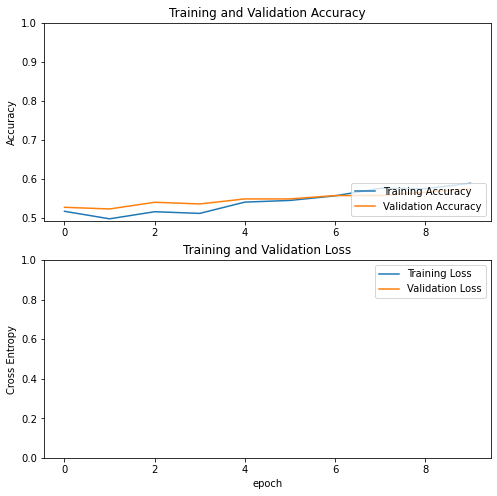

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
base_model.trainable = True

In [34]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 1

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


In [35]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.add (TFOpLambda)     (None, 160, 160, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [32]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(ds_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_val)

Epoch 10/25
59/59 [==============================] - 52s 814ms/step - loss: 1.2224 - accuracy: 0.5829 - val_loss: 1.0970 - val_accuracy: 0.5751
Epoch 11/25
59/59 [==============================] - 65s 1s/step - loss: 1.1463 - accuracy: 0.5818 - val_loss: 1.0931 - val_accuracy: 0.5751
Epoch 12/25
59/59 [==============================] - 68s 1s/step - loss: 1.1140 - accuracy: 0.5904 - val_loss: 1.0891 - val_accuracy: 0.5794
Epoch 13/25
59/59 [==============================] - 74s 1s/step - loss: 1.1719 - accuracy: 0.5872 - val_loss: 1.0859 - val_accuracy: 0.5837
Epoch 14/25
36/59 [=================>............] - ETA: 18s - loss: 1.1044 - accuracy: 0.6250

KeyboardInterrupt: 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = model.predict(ds_val)

b =0
m = 0
for element in predictions :
    if(element[0] > 0.5) :
        m +=1
    elif(element[0]< 0.5) :
        b +=1
        
print("Prédictions ;\n - Malin(s): ", m, "\n - Bénins: ", b, "\n - Total comp: ", b+m," vs ",len(predictions))

In [ ]:
from sklearn.metrics import plot_confusion_matrix  

def predict_class_label_number(dataset):
    predictions =  model.predict(dataset)
    res = np.zeros(len(predictions))
    i = 0 
    for element in predictions : 
        if(element[0]> 0.5):
            res[i] = 1
        i += 1
    return tf.convert_to_tensor(res)

def give_labels (dataset, size):
    lab = np.zeros(size)
    i = 0
    for batch in dataset:
        for element in batch[1] :
            lab[i] = element.numpy()
            i +=1
    return tf.convert_to_tensor(lab)
    
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(5,5))
    plt.imshow(cm)
    plt.colorbar()
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [ ]:
dataset = ds_val
confusion_mtx = tf.math.confusion_matrix(
    give_labels(dataset, size),
    predict_class_label_number(dataset),
    num_classes=2)
show_confusion_matrix(confusion_mtx, [0,1])